In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.io import wavfile
import os
import numpy as np

IMPORTING FILE

Audio data shape is
(141120, 2)


Text(0.5, 1.0, 'Audio signal in time')

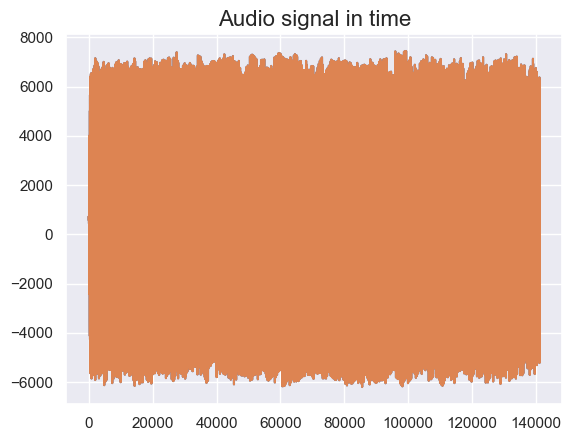

In [2]:
""" Note: Each sample in my set releases the note halfway.
False -> we train with the release behavior (not a good idea).
True -> we don't, and we only use the first half of each sample.
"""
dont_use_release = True

SampleName = "01 - [Prologue]_1.wav" # Audio File
os.chdir('./data/wav/')
SampleRate, Audiodata = wavfile.read(SampleName)

if dont_use_release:
    Audiodata = Audiodata[0:len(Audiodata)//2,:]

print('Audio data shape is') #Old shape was (35280,2)
print(np.shape(Audiodata))

# Plot the audio signal in time
plt.plot(Audiodata)
plt.title('Audio signal in time',size=16)

FAST FOURIER TRANSFORM \& SPECTRUM

FFT of audio data shape is
(8192,)


(0.0, 0.6)

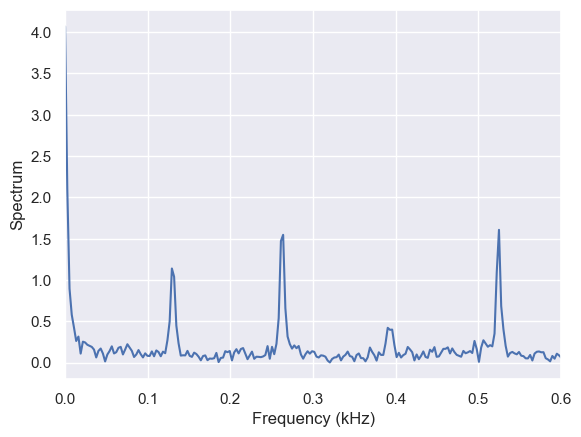

In [10]:
# spectrum
from scipy.fft import fft # fourier transform
m = len(Audiodata) 
FFTSize = 16384 # have to use a multiple of 2 for optimal speed. Old was 8192
#AudioFreq = fft(Audiodata,n=FFTSize,axis=0)
AudioFreq = fft(Audiodata[:,1]*np.hanning(np.shape(Audiodata)[0]),n=FFTSize,axis=0) #with a Hanning window
AudioFreq = AudioFreq[0:int(np.ceil((np.shape(AudioFreq)[0])/2.0))] #Left half of the spectrum
MagFreq = np.abs(AudioFreq) # Magnitude
MagFreq = MagFreq / float(m)

print('FFT of audio data shape is') # Old shape was (4096,)
print(np.shape(MagFreq))

plt.figure()
freqAxis = np.arange(0,int(np.ceil((m+1)/2.0)), int(np.ceil((m+1)/2.0))*2/FFTSize) * (SampleRate / m);
#freqAxis = np.arange(0,int(np.ceil((m+1)/2.0)), int(np.ceil((m+1)/2.0))/FFTSize) * (SampleRate / m);
plt.plot(freqAxis/1000.0, MagFreq) #Spectrum
plt.xlabel('Frequency (kHz)'); plt.ylabel('Spectrum');
plt.xlim([0, 0.6])

POWER SPECTRUM

(0.0, 2.0)

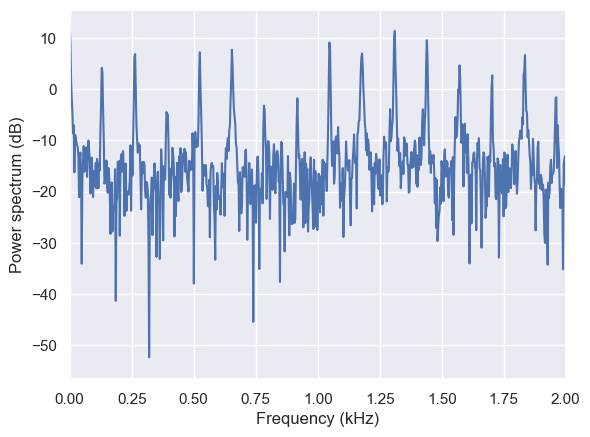

In [11]:
# power spectrum
MagFreq = MagFreq**2
if m % 2 > 0: # ffte odd 
    MagFreq[1:len(MagFreq)] = MagFreq[1:len(MagFreq)] * 2
else:# fft even
    MagFreq[1:len(MagFreq) -1] = MagFreq[1:len(MagFreq) - 1] * 2 

plt.figure()
plt.plot(freqAxis/1000.0, 10*np.log10(MagFreq)) #Power spectrum
plt.xlabel('Frequency (kHz)'); plt.ylabel('Power spectrum (dB)');
plt.xlim([0, 2])

FINDING THE FUNDAMENTAL FREQUENCY

In [12]:
# HPS (Harmonic Product Spectrum) Algorithm to determine fundamental frequency

HPSSizeFloat = len(MagFreq)/3.0
HPSSize = int(np.ceil(len(MagFreq))/3.0 + 1)

MagFreq2 = MagFreq.copy().reshape(int(np.ceil(len(MagFreq))/2.0),2).mean(1)[0:HPSSize]
MagFreq3 = np.concatenate([MagFreq.copy(),np.zeros(3 - int(len(MagFreq)) % 3)]).reshape(int(np.ceil(len(MagFreq))/3.0 + 1),3).mean(1)[0:HPSSize]

#MagFreq2 = MagFreq.copy().reshape(int(np.ceil(len(MagFreq))/2.0),2).mean(1)[0:HPCSize]
print(np.shape(MagFreq2))
#MagFreq3 = np.concatenate([MagFreq.copy(),np.zeros(3 - int(len(MagFreq)) % 3)]).reshape(int(np.ceil(len(MagFreq))/3.0 + 1),3).mean(1)[0:HPCSize]
print(np.shape(MagFreq3))

HPS = MagFreq[0:HPSSize]*MagFreq2*MagFreq3
#HPCLog = np.log10(MagFreq[0:HPCSize])*np.log10(MagFreq2)*np.log10(MagFreq3)

freqAxisDownscaled = np.arange(0,int(np.ceil((m+1)/2.0)), int(np.ceil((m+1)/2.0))*6/FFTSize) * (SampleRate / m);
FFLocHPS = np.argmax(HPS[freqAxisDownscaled >= 50]) + int(len(HPS[freqAxisDownscaled < 50])) # don't look below 50 Hz for it, due to noise.



FFLocation = (FFLocHPS-1)*3 # FFLocHPS uses an index that is scaled down by 1/3. Have to reverse that.

#FFLocation = np.argmax(HPC)
#FFLocationLog = np.argmax(HPCLog)
print('Fundamental frequency\'s location is at index... ',FFLocation)
print('Fundamental frequency is...',freqAxis[FFLocation],'Hz.')
#print('(Using power spectrum) Fundamental frequency\'s location is at index... ',FFLocationLog)
#print('(Using power spectrum) Fundamental frequency is...',freqAxis[FFLocationLog],'Hz.')

(2731,)
(2731,)
Fundamental frequency's location is at index...  1455
Fundamental frequency is... 3916.40682220459 Hz.


ASSESSING ACCURACY OF THE FF \& MEASURING SPIKES

In [13]:
# Have to ensure the fundamental frequency is accurate. Take loudest spike, get its approximate ratio, round to nearest int.
MaxLoc = np.argmax(MagFreq[freqAxis >= 50]) + int(len(MagFreq[freqAxis < 50])) # don't look below 50 Hz for it, due to noise.
MaxRatio = np.max([np.round(freqAxis[MaxLoc]/freqAxis[FFLocation]), 1])
#MaxRatioLog = np.round(freqAxis[MaxLoc]/freqAxis[FFLocationLog])
print('The loudest ratio is ',MaxRatio)
#print('(Using power spectrum) The loudest ratio is ',MaxRatioLog)

FFreq = freqAxis[MaxLoc]/MaxRatio
print('Corrected fundamental frequency is ',FFreq,' Hz.')

MagFreqLog = 10*np.log10(MagFreq)
FFreqLoc = np.argmin(np.abs(freqAxis - FFreq))
print('Closest match found at index ',FFreqLoc)

# If the frequency immediately on either side of each "spike" is louder, make that the new spike.
FFreqLoc = FFreqLoc - ((MagFreqLog <= np.roll(MagFreqLog,1)) & (np.roll(MagFreqLog,-1) <= np.roll(MagFreqLog,1))) #if the left entry is >= the entry and the right entry, then make the left entry the new spike location
FFreqLoc = FFreqLoc + ((MagFreqLog <= np.roll(MagFreqLog,-1)) & (np.roll(MagFreqLog,1) <= np.roll(MagFreqLog,-1)))  #if the right entry is >= the entry and the left entry, then make the right entry the new spike location

numberSpikes = 20
Multiples = [FFreq*i for i in np.arange(0,numberSpikes)]
Multiples[0] = FFreq/2 # It turns out, telling the YM2612 to use the "0th" multiple means 1/2 the FF.
print(Multiples)

MultiplesLoc = [np.argmin(np.abs(freqAxis - i)) for i in Multiples]
print(MultiplesLoc)

# Next, make an integer ratio-indexed list of the amplitudes!

MultiplesMag = MagFreq[MultiplesLoc]
print(MultiplesMag)

MultiplesdB = MagFreqLog[MultiplesLoc]
print(MultiplesdB)

The loudest ratio is  1.0
Corrected fundamental frequency is  1310.8523178100586  Hz.
Closest match found at index  487
[655.4261589050293, 1310.8523178100586, 2621.704635620117, 3932.556953430176, 5243.409271240234, 6554.261589050293, 7865.113906860352, 9175.96622467041, 10486.818542480469, 11797.670860290527, 13108.523178100586, 14419.375495910645, 15730.227813720703, 17041.08013153076, 18351.93244934082, 19662.78476715088, 20973.637084960938, 22284.489402770996, 23595.341720581055, 24906.194038391113]
[243, 487, 974, 1461, 1948, 2435, 2922, 3409, 3896, 4383, 4870, 5357, 5844, 6331, 6818, 7305, 7792, 8191, 8191, 8191]
[5.79833043e+00 1.34679006e+01 2.42639961e+00 5.81511482e-01
 1.73499199e-01 1.40098641e-03 6.01584818e-02 3.27254114e-02
 2.85711505e-02 1.09437708e-01 2.50602957e-03 2.51719749e-02
 4.68421072e-04 6.60910158e-02 4.73804762e-03 7.37315726e-03
 5.35106253e-02 1.04617924e-02 1.04617924e-02 1.04617924e-02]
[  7.63302961  11.29299903   3.84962328  -2.35441705  -7.60702527
